In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from typing import List
%matplotlib inline

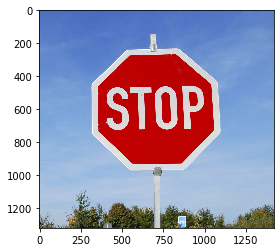

In [2]:

class Augmentation(object):
    
    @staticmethod
    def flip(img:np.ndarray,axis:int) -> np.ndarray:#
        '''
            Flips image on specified axis
            @parma img = image np.ndarray
            @param axis: integer,
                -1 - flip both axis, mirored upside down
                 0 - Vertical flip axis 0 , upside down
                 1 - Horizontal flip axis 1, mirror image

            @return fliped image type numpy.ndarray
        '''
        return cv2.flip(img,axis)
    
    @staticmethod
    def rotate(img, angle:float)-> np.ndarray:
        '''
            Rotationg image anti-clockwise if given positive number,clockwise if give negative
            
            @parma img = image np.ndarray
            @param angle: float, in degrees 
            
            @return rotated image. type numpy.ndarray
        '''
        centerH,centerW = img.shape[0]//2,img.shape[1]//2
        rotation_matrix = cv2.getRotationMatrix2D((centerW, centerH), angle, 1)
        return cv2.warpAffine(img, rotation_matrix, (img.shape[1],img.shape[0]))
    
    @staticmethod
    def gaussian_blur(img, ksize:int,sigma:int) -> np.ndarray:
        '''
            @parma img = image np.ndarray
            @param ksize: int, the row,cols dimension of the kernel
            @param sigma: int, statdard deviation to help calculate cells
            
            @return blured image type numpy.ndarray
        '''
        return cv2.GaussianBlur(img,ksize=(ksize,ksize),sigmaX=sigma, borderType=cv2.BORDER_DEFAULT)
    
    @staticmethod
    def median_blur(img, ksize:int) -> np.ndarray:
        '''
            @parma img = image np.ndarray
            @param ksize: int, the row,cols dimension of the kernel
            
            @return blured image type numpy.ndarray
        '''
        return cv2.medianBlur(img,ksize)
    
    @staticmethod
    def zoom(img, zoom_factor:int)-> np.ndarray:
        '''
            Zooms on center of the image
            
            @parma img = image np.ndarray
            @param pos: tuple, return image from what postion 
            @return nd.array, zoomed image
        '''
        height, width = img.shape[:2] 
        new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

        h1, w1 = (new_height - height) // 2,(new_width - width) // 2
        h2, w2 = h1 + height, w1 + width
        
        pos = (np.array([h1, w1])/ zoom_factor).astype(int)
        size = (np.array([h2-h1,w2-w1]) / zoom_factor).astype(int)
        
        cropped_img = Augmentation.crop(img, tuple(pos), tuple(size))
         
        return cv2.resize(cropped_img, (width,height))
    
    @staticmethod
    def crop(img, pos:tuple, size:tuple) -> np.ndarray:
        '''
            @parma img = image np.ndarray
            @param pos: tuple, return image from pos[x,y] postion 
            @param size: tuple, return image dimensions
            
            return nd.array, croped image
        '''
        newH = np.min([pos[0]+size[0],img.shape[0]])
        newW = np.min([pos[1]+size[1],img.shape[1]])
            
        return img[pos[0]:newH,pos[1]:newW]
    
    
    
    
image = plt.imread('./images/stopsign.jpg')
plt.imshow(image)
plt.show()

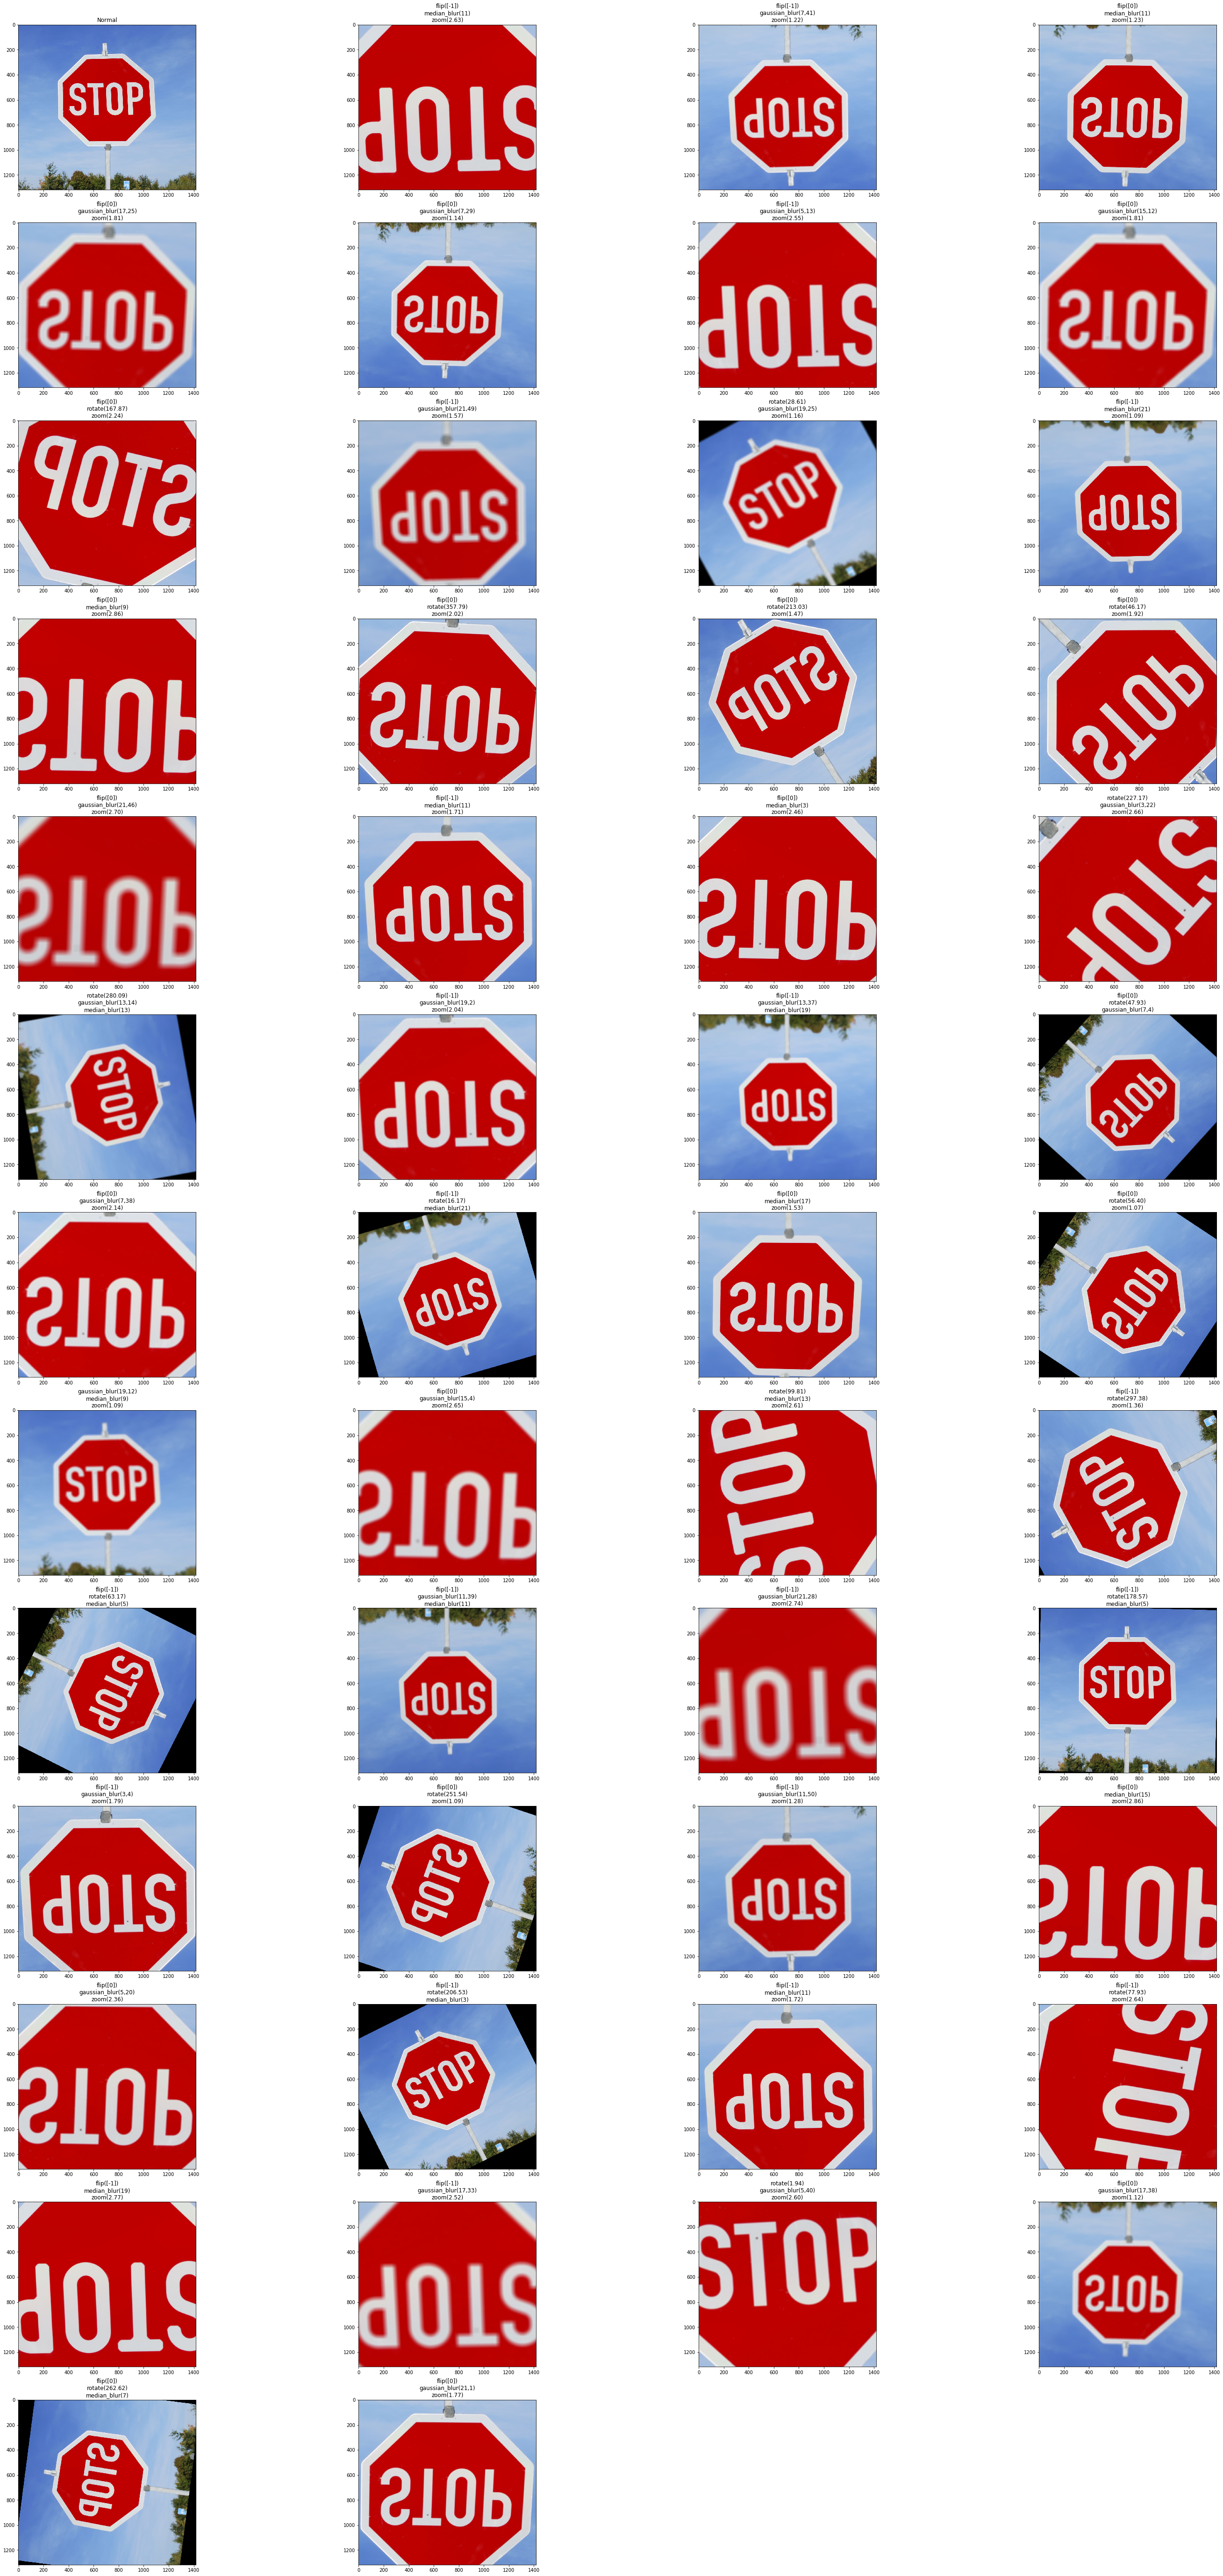

In [3]:
class RandomAugmentation(Augmentation):
    
    
    def __init__(self,image:np.ndarray, N:int, M:List[float]):
        self.image = image
        self.N = N
        self.M = M
        self.augmented_images = {'Normal':self.image}
        self.augmentations = [func for func in dir(Augmentation) 
                              if callable(getattr(Augmentation, func)) 
                                  and not func.startswith("__")]
        
    def augment_image(self, permutations:list):
        key = ''
        img = np.copy(self.image)
        
        if 'flip' in permutations:
            
            axis = np.random.randint(-1,1,1)
            img = super().flip(img=img,axis=axis)
            key+=f'flip({axis})\n'
        
        if 'rotate' in permutations:
            angle = np.random.uniform(0, 360)
            img = super().rotate(img,angle=angle)
            key+=f'rotate({angle:.2f})\n'
            
        if 'gaussian_blur' in permutations:
            ksize = np.random.randint(1,11)*2 +1
            sigma = np.random.randint(1,51)
            img = super().gaussian_blur(img,ksize=ksize,sigma=sigma)
            key+=f'gaussian_blur({ksize},{sigma})\n'
        
        if 'median_blur' in permutations:
            ksize = np.random.randint(1,11)*2 +1
            img = super().median_blur(img, ksize=ksize)
            key+=f'median_blur({ksize})\n'
            
        if 'zoom' in permutations: 
            zoom = np.random.uniform(1,3)
            img = super().zoom(img, zoom_factor=zoom)
            key+=f'zoom({zoom:.2f})\n'
            
        if 'crop' in permutations:
            x = np.random.randint(100,img.shape[0])
            y = np.random.randint(100,img.shape[1])
            h = np.random.randint(100,img.shape[0])
            w = np.random.randint(100,img.shape[1])
            pos=(x,y)
            size=(h,w)
            img = super().crop(img,pos,size)
            key+=f'crop({pos},{size})\n'
            
        self.augmented_images[key[:-1]] = img
            
        
    def generate_augmented_images(self,num_out,show = False):
        for n in range(1,num_out+1):
            permutations = np.random.choice(self.augmentations,self.N,replace=False,p=self.M)
            self.augment_image(permutations)
        if show:
            self.show_augmented_images()
            
    def show_augmented_images(self):
        total = len(self.augmented_images)
        in_col = 4
        in_row = (total//in_col) + 1
        plt.figure(figsize=[total ,total*2])
        for index,(k,v) in enumerate(self.augmented_images.items()):
            plt.subplot(in_row, in_col, index+1)
            plt.title(k)
            plt.imshow(v)
        plt.show()

    def show_propabilities(self):
        print("\t\tPropabilities")
        for p in zip(self.augmentations,self.M):
            print(p)
        
        
ra = RandomAugmentation(image,N=3,M=[0.,0.4,0.1,0.1,0.1,0.3])   
ra.generate_augmented_images(50,show=True)


In [4]:
ra.show_propabilities()

		Propabilities
('crop', 0.0)
('flip', 0.4)
('gaussian_blur', 0.1)
('median_blur', 0.1)
('rotate', 0.1)
('zoom', 0.3)
